<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tenpy-optimization" data-toc-modified-id="Tenpy-optimization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tenpy optimization</a></span><ul class="toc-item"><li><span><a href="#Model-definitions" data-toc-modified-id="Model-definitions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Model definitions</a></span><ul class="toc-item"><li><span><a href="#Def.-XXZ-MPO" data-toc-modified-id="Def.-XXZ-MPO-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Def. XXZ MPO</a></span></li></ul></li><li><span><a href="#Setup-variational-circuit-ansatz" data-toc-modified-id="Setup-variational-circuit-ansatz-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Setup variational circuit ansatz</a></span></li><li><span><a href="#Optimize-the-variational-parameters" data-toc-modified-id="Optimize-the-variational-parameters-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Optimize the variational parameters</a></span><ul class="toc-item"><li><span><a href="#Compare-to-DMRG-results-at-same-bond-dimension" data-toc-modified-id="Compare-to-DMRG-results-at-same-bond-dimension-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Compare to DMRG results at same bond-dimension</a></span></li><li><span><a href="#Look-at-correlation-functions" data-toc-modified-id="Look-at-correlation-functions-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Look at correlation functions</a></span></li></ul></li><li><span><a href="#Optimize-bond-prep-circuit" data-toc-modified-id="Optimize-bond-prep-circuit-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Optimize bond-prep circuit</a></span></li></ul></li><li><span><a href="#Simulate-in-Qiskit" data-toc-modified-id="Simulate-in-Qiskit-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulate in Qiskit</a></span><ul class="toc-item"><li><span><a href="#Simulate-implementation-in-qiskit-(without-noise)" data-toc-modified-id="Simulate-implementation-in-qiskit-(without-noise)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Simulate implementation in qiskit (without noise)</a></span><ul class="toc-item"><li><span><a href="#Setup-simulations" data-toc-modified-id="Setup-simulations-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Setup simulations</a></span></li><li><span><a href="#Run-Sims-(Noiseless)" data-toc-modified-id="Run-Sims-(Noiseless)-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Run Sims (Noiseless)</a></span></li></ul></li><li><span><a href="#Compare-Qiskit-and-Tenpy-results" data-toc-modified-id="Compare-Qiskit-and-Tenpy-results-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Compare Qiskit and Tenpy results</a></span></li><li><span><a href="#Correlation-functions" data-toc-modified-id="Correlation-functions-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Correlation functions</a></span></li><li><span><a href="#Noisy-Qiskit-Simulations" data-toc-modified-id="Noisy-Qiskit-Simulations-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Noisy Qiskit Simulations</a></span><ul class="toc-item"><li><span><a href="#Noise-model" data-toc-modified-id="Noise-model-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Noise model</a></span></li><li><span><a href="#Run-Simulation" data-toc-modified-id="Run-Simulation-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Run Simulation</a></span></li></ul></li></ul></li><li><span><a href="#Thermal-state" data-toc-modified-id="Thermal-state-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Thermal state</a></span></li><li><span><a href="#Dynamics" data-toc-modified-id="Dynamics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dynamics</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..") # import one subdirectory up in files
#sys.path.append("..") # import one subdirectory up in files
#os.chdir("../holopy/")

# standard imports
import numpy as np
from scipy.optimize import minimize
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
import time as time
#import json
import pickle

# 3rd party packages
import qiskit as qk
import qiskit.providers.aer.noise as noise
import tenpy as tp

## custom things
from networks.networks import IsoMPS
from networks.isonetwork import QKParamCircuit
import circuits.basic_circuits as circuits
import mps.mps as mps



# Tenpy optimization
## Model definitions
Define some functions to create tenpy MPO for xxz model

### Def. XXZ MPO

In [3]:
## TENPY FUNCTION DEFINITIONS ##

from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import asConfig
from tenpy.networks.site import SpinHalfSite
from tenpy.networks.mps import MPS

__all__ = ['XXZModel', 'XXChain']
class XXZModel(CouplingMPOModel):
    def init_sites(self, model_params):
        conserve = model_params.get('conserve', 'parity')
        assert conserve != 'Sz'
        if conserve == 'best':
            conserve = 'parity'
            if self.verbose >= 1.:
                print(self.name + ": set conserve to", conserve)
        site = SpinHalfSite(conserve=conserve)
        return site
    def init_terms(self, model_params):
        J = np.asarray(model_params.get('J', 1.))
        d = np.asarray(model_params.get('d', 1.))
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(J, u1, 'Sigmax', u2, 'Sigmax', dx)
            self.add_coupling(J, u1, 'Sigmay', u2, 'Sigmay', dx)
            self.add_coupling(J*d, u1, 'Sigmaz', u2, 'Sigmaz', dx)
        # done
class XXZChain(XXZModel, NearestNeighborModel):
    def __init__(self, model_params):
        model_params = asConfig(model_params, self.__class__.__name__)
        model_params.setdefault('lattice', "Chain")
        CouplingMPOModel.__init__(self, model_params)
        
def DMRG_xxz_infinite(J,Delta,chi_max = 4, verbose=False):
    model_params = dict(L=2, J=J, d=Delta, bc_MPS='infinite', conserve=None, verbose=verbose)
    M = XXZChain(model_params)
    product_state = ["down"] * M.lat.N_sites
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,  # setting this to True helps to escape local minima
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-6
        },
        'max_E_err': 1.e-6,
        'verbose': verbose,
    }
    # Sometimes, we want to call a 'DMRG engine' explicitly
    eng = tp.algorithms.dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    E, psi = eng.run()  # equivalent to dmrg.run() up to the return parameters.
    print("E = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi)
    mag_x = np.mean(psi.expectation_value("Sigmax"))
    mag_z = np.mean(psi.expectation_value("Sigmaz"))
    print("<sigma_x> = {mag_x:.5f}".format(mag_x=mag_x))
    print("<sigma_z> = {mag_z:.5f}".format(mag_z=mag_z))
    print("correlation length:", psi.correlation_length())
    return E, psi, M

def xxz_mpo(J,Delta,hz=0):
    model_params = dict(J=J, d=Delta, bc_MPS='infinite', conserve=None, verbose=False)
    return XXZChain(model_params).H_MPO

test = xxz_mpo(1.0,1.0)
print(test.__dict__)

#def xxz_mpo(J, Delta, hz, N=1, bc='infinite'):
#    site = tp.networks.site.SpinHalfSite(None)
#    Id, Sp, Sm, Sz = site.Id, site.Sp, site.Sm, 2*site.Sz
#    W_bulk = [[Id, Sp, Sm, Sz, -hz * Sz],
#              [None, None, None, None, 0.5 * J * Sm],
#              [None, None, None, None, 0.5 * J * Sp],
#              [None, None, None, None, J * Delta * Sz],
#              [None, None, None, None, Id]]
#    H = tp.networks.mpo.MPO.from_grids([site], [W_bulk], bc, IdL=0, IdR=-1) # (probably leave the IdL,IdR)
#    return H

#def xxz_mpo(J, Delta, hz, N=1, bc='infinite'):
#    site = tp.networks.site.SpinHalfSite(None)
#    Id, Sp, Sm, Sz = site.Id, site.Sp, site.Sm, 2*site.Sz
#    W_bulk = [[Id, Sp, Sm, Sz, -hz * Sz],
#              [None, None, None, None, 0.5 * J * Sm],
#              [None, None, None, None, 0.5 * J * Sp],
#              [None, None, None, None, J * Delta * Sz],
#              [None, None, None, None, Id]]
    #W_first = [W_bulk[0]]  # first row
    #W_last = [[row[-1]] for row in W_bulk]  # last column
    #Ws = [W_first] + [W_bulk]*(N - 2) + [W_last]
#    H = tp.networks.mpo.MPO.from_grids([site]*N, [W_bulk]*N, bc, IdL=0, IdR=-1) # (probably leave the IdL,IdR)
#    return H

# tenpy energy calculator
def energy_tp(param_vals,*args):
    """
    function to calculate energy using MPO/MPS contraction in tenpy
    inputs:
        - param_vals = dict {parameter:value}
        - *args, 
            args[0] should be psi: state as IsoMPS
            args[1] should be H_mpo: Hamiltonian as MPO
        (input made this way to be compatible w/ scipy.optimize)
    outputs:
        - float, <psi|H|psi> computed w/ tenpy
    """
    # parse inputs
    psi=args[0] # state as isoMPS    
    H_mpo = args[1] # Hamiltonian as tenpy MPO
    param_dict = dict(zip(psi.param_list,param_vals))
    
    # convert state from holoPy isoMPS to tenpy MPS
    psi_tp = psi.to_tenpy(param_dict,L=np.inf)
    
    # compute energy
    E = (H_mpo.expectation_value(psi_tp)).real
    return E

def energy_tp_corr(param_vals,*args):
    psi=args[0]
    J,Delta,h = args[1]
    psi_tp=psi.to_tenpy(opt_params,L=np.inf)
    Cxx_tp = np.mean([4*psi_tp.correlation_function("Sx", "Sx", 
                                                 sites1=[j], 
                                                 sites2=[j+1],
                                                 opstr=None, str_on_first=False, hermitian=False, autoJW=False)
                      for j in range(l_uc)])
    Cyy_tp = np.mean([4*psi_tp.correlation_function("Sy", "Sy", 
                                                 sites1=[j], 
                                                 sites2=[j+1],
                                                 opstr=None, str_on_first=False, hermitian=False, autoJW=False)
                      for j in range(l_uc)])
    Czz_tp = np.mean([4*psi_tp.correlation_function("Sz", "Sz", 
                                                 sites1=[j], 
                                                 sites2=[j+1],
                                                 opstr=None, str_on_first=False, hermitian=False, autoJW=False)
                      for j in range(l_uc)])
    return J*(Cxx_tp+Cyy_tp+Delta*Czz_tp)

{'sites': [SpinHalfSite(None), SpinHalfSite(None)], 'chinfo': ChargeInfo([], []), 'dtype': dtype('complex128'), '_W': [<npc.Array shape=(5, 5, 2, 2) charge=ChargeInfo([], []) labels=['wL', 'wR', 'p', 'p*']>, <npc.Array shape=(5, 5, 2, 2) charge=ChargeInfo([], []) labels=['wL', 'wR', 'p', 'p*']>], 'IdL': [0, 0, 0], 'IdR': [4, 4, 4], 'grouped': 1, 'bc': 'infinite', 'max_range': 1, 'explicit_plus_hc': False}


## Setup variational circuit ansatz
Setup variational circuit ansatz
Strategy: two-site unit-cell, with star-circuit of xxz-gates:

$$U_{xxz}(\theta,\phi) = \exp[-i\theta/2 (X_1X_2+Y_1Y_2) - i\phi/2(Z_1Z_2)] $$

and initial state for qubits alternates between $|\uparrow\rangle$, $|\downarrow\rangle$ on even/odd sites of the unit-cell

First, define the parameters of the model and circuit:

In [6]:
## HYPERPARAMETERS ##
# model (xxz)
J = 1.0 # spin-exchange
Delta = 1.25 # Ising-anisotropy
hz = 0.0 # z-field

# ansatz parameters
nb = 2 # number of bond-qubits 
L = 1 # number of unit cells
l_uc = 2 # number of sites in unit cell
n_site_param = 2*nb # number of circuit parameters per site
# number of bond circuit parameters
use_bond_prep = True

if use_bond_prep:
    if nb==1: n_bond_params=3
    elif nb==2: n_bond_params=15 
else:
    n_bond_params=0 

Next, setup the circuit as a parameterized circuit in qiskit (which we package as a QKParamCircuit, and create a holopy IsoMPS object from)

Note: here, I haven't setup the bond-qubit initialization circuit (bond_prep_circ): this doesn't effect tenpy-part which computes for infinite boundary conditions.

To-do: optimize bond-qubit initialization circuit to minimize required burn-in

circuits for each site in uc:


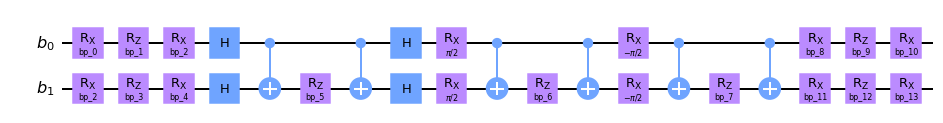

In [20]:
## CREATE ISOMPS FROM PARAMETERIZED CIRCUIT ANSATZ ##
# initialize registers
preg = qk.QuantumRegister(1,'p') # physical qubits
breg = qk.QuantumRegister(nb,'b') # bond qubits
#creg = qk.ClassicalRegister(L*l_uc+nb,'m') # classical register to hold measurement outcomes

## Bond-state prep-circuit ##
bond_prep_params = [qk.circuit.Parameter('bp_'+str(j)) 
                    for j in range(n_bond_params)]
bond_prep_circ = qk.QuantumCircuit(breg)
if use_bond_prep:
    if nb==1: circuits.add_1q_circ(bond_prep_circ, breg[0], bond_prep_params) 
    elif nb==2: circuits.add_su4_circ(bond_prep_circ, breg[0],breg[1], bond_prep_params) 
else:
    bond_prep_circ.ry(0.234,breg)

# turn into custom parameterized circuit object
bond_prep_pcirc = QKParamCircuit(bond_prep_circ,bond_prep_params)


## Site Circuits ##
# create list of circuits, one for each site in the unit cell (uc)
site_circs = [qk.QuantumCircuit(preg,breg) for j in range(l_uc)]
# create a list of parameter-lists, (one list of parameters per site in uc)
site_circ_params = [[qk.circuit.Parameter('s'+str(j)+'_'+str(k))
                     for k in range(n_site_param)] 
                    for j in range(l_uc)]
site_pcircs=[] # list of QKParamCirc's for each site in uc
for j in range(l_uc):
    if j%2==0: site_circs[j].x(preg[0]) # alternating 10101010... for physical qubit
    
    # star circuit of xxz-type 2-qubit gates
    for k in range(nb): 
        circuits.add_xxz_circ(site_circs[j], 
                              preg[0], breg[k], 
                              site_circ_params[j][2*k:2*(k+1)])
    # combine into parameterized circuit
    site_pcircs += [QKParamCircuit(site_circs[j], site_circ_params[j])]

# create holopy isoMPS
psi = IsoMPS(preg,breg,site_pcircs,boundary_circuit=bond_prep_pcirc,L=1)

print('circuits for each site in uc:')
#site_circs[1].draw('mpl')
bond_prep_circ.draw('mpl')

## Optimize the variational parameters 
Minmize the variational energy using scipy.optimize

In [8]:
## OPTIMIZE CIRCUIT PARAMETERS CLASSICALLY IN TENPY ##
# create tenpy mpo
H_mpo = xxz_mpo(J=J,hz=hz,Delta=Delta)


x0 = np.pi*np.random.randn(psi.n_params) # starting point for parameters
t0 = time.time()
opt_result = minimize(energy_tp, # function to minimize
                      x0, # starting point for parameters 
                      args=(psi,H_mpo), # must take form (isoMPS,tenpy MPO, Length)
                      method='BFGS'
                     )
tf = time.time()
# set parameters to previously optimized values
opt_vals = opt_result.x
opt_params = dict(zip(psi.param_list,opt_vals))
E_gs_tp = opt_result.fun
print('Optimization done, elapsed time: {}'.format(tf-t0))
print('Optimized energy = {}'.format(E_gs_tp))
print('Optimized parameters')
print(opt_params)

KeyboardInterrupt: 

In [17]:
## good variational parameters for nb=2=l_uc
## chosen from a couple of runs based on matching dmrg
good_param_vals = np.array([-5.47986438,-2.98024345, -1.18519139,
                            1.19707353, -1.48805789,  3.45880091,
                            2.43144225,  3.66370337])
if use_bond_prep:
    good_param_vals = np.concatenate((np.zeros(n_bond_params),good_param_vals))
opt_params = dict(zip(psi.param_list,good_param_vals))
print(opt_params)

{Parameter(bp_0): 0.0, Parameter(bp_1): 0.0, Parameter(bp_2): 0.0, Parameter(bp_3): 0.0, Parameter(bp_4): 0.0, Parameter(bp_5): 0.0, Parameter(bp_6): 0.0, Parameter(bp_7): 0.0, Parameter(bp_8): 0.0, Parameter(bp_9): 0.0, Parameter(bp_10): 0.0, Parameter(bp_11): 0.0, Parameter(bp_12): 0.0, Parameter(bp_13): 0.0, Parameter(bp_14): 0.0, Parameter(s0_0): -5.47986438, Parameter(s0_1): -2.98024345, Parameter(s0_2): -1.18519139, Parameter(s0_3): 1.19707353, Parameter(s1_0): -1.48805789, Parameter(s1_1): 3.45880091, Parameter(s1_2): 2.43144225, Parameter(s1_3): 3.66370337}


### Compare to DMRG results at same bond-dimension

In [12]:
chi = 2**nb # DMRG w/ same bond-dimension as vqe
#chi = 32 # DMRG w/ larger bond dimension ("exact")
E_dmrg,psi_dmrg,H_mpo = DMRG_xxz_infinite(J,Delta,chi_max = chi, verbose=True)

print()
print('-- done --')
print('DMRG GS energy = {:0.2F}'.format(E_dmrg))
print('Tenpy-vqe GS energy = {:0.2F}'.format(E_gs_tp))
print('Relative percent error = {:0.2F}%'.format(100*(1-E_gs_tp/E_dmrg)))

Reading 'bc_MPS'='infinite' for config XXZChain
Reading 'conserve'=None for config XXZChain
Reading 'L'=2 for config XXZChain
Reading 'J'=1.0 for config XXZChain
Reading 'd'=1.25 for config XXZChain
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Updating environment
.
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 128
Energy = -1.9128677841849466, S = nan, norm_err = 2.9e-05
Current memory usage 202288.0 MB, time elapsed: 1.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6159e-03, max_E_trunc = 1.4462e-02
MPS bond dimensions: [4, 4]
disable mixer after 15 sweeps, final amplitude 3.05e-10
Updating environment
.....
sweep 20, age = 248
Energy = -1.9128693727109720, S = 0.5971810004699853, norm_err = 3.8e-09
Current memory usage 202292.0 MB, time elapsed: 2.9 s
Delta E = -1.5885e-07, Delta S = nan (per sweep

/Users/acpotter/anaconda3/envs/tenpy/lib/python3.9/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


NameError: name 'E_gs_tp' is not defined

### Look at correlation functions

In [13]:
sites1 = [0]
sites2 = [j for j in range(1,20)]

# Correlators from DMRG
C_dmrg = {}
C_dmrg['x'] = 4*psi_dmrg.correlation_function("Sx", "Sx",sites1=sites1,sites2=sites2)
C_dmrg['y'] = 4*psi_dmrg.correlation_function("Sx", "Sx",sites1=sites1,sites2=sites2)
C_dmrg['z'] = 4*psi_dmrg.correlation_function("Sz", "Sz",sites1=sites1,sites2=sites2)

# correlators from qMPS/vqe
psi_tp=psi.to_tenpy(opt_params,L=np.inf)
C_tpvqe = {}
C_tpvqe['x'] = 4*psi_tp.correlation_function("Sx", "Sx",sites1=sites1,sites2=sites2)
C_tpvqe['y'] = 4*psi_tp.correlation_function("Sx", "Sx",sites1=sites1,sites2=sites2)
C_tpvqe['z'] = 4*psi_tp.correlation_function("Sz", "Sz",sites1=sites1,sites2=sites2)

plt.figure(figsize=(15,4))
for j,b in enumerate(['x','y','z']):
    plt.subplot(1,3,j+1)
    plt.plot(C_dmrg[b][0],'--')
    plt.plot(C_tpvqe[b][0],'.-')
    plt.legend(['dmrg $\chi$={}'.format(chi),'vqe (tenpy)'])
    plt.title('DMRG results: $C_'+b+'(0,r)$ correlators, r=0')
    plt.ylim([-1,1])
    plt.xlabel('r')

KeyError: Parameter(s0_0)

## Optimize bond-prep circuit

In [18]:
## Extract transfer matrix and bond-steady-state from optimized mps ##
psi_mps = psi.as_mps(opt_params) # psi_mps as custom mps object
tmat = psi_mps.transfer_matrix() # transfer matrix for unit cell
vals,vecs = la.eig(tmat) # eigenvalues
rho_ss = vecs[:,0] # steady state

## Optimize overlap with steady state


CircuitError: "Cannot bind parameters (['bp_14']) not present in the circuit."

# Simulate in Qiskit
## Simulate implementation in qiskit (without noise)

In [ ]:
## POSTPROCESSING FUNCTIONS ##
def counts_to_correlators(counts,shots):
    """
    converts qiskit-style counts result 
    to NxN numpy array of 2-point correlatrs
    w/ N = # of sites in isoMPS = L*l_uc
    """
    # number of sites (compute from input dictionary shape)
    N = len(list(counts.keys())[0].split(" ")) 
    C = np.zeros((N,N))
    # loop over each measurement outcome
    for k in counts.keys(): 
        split_list = k.split(" ")[:] # split bits from each register
        # note that qiskit typically orders in reverse order 
        # NOTE: WILL NEED TO REVISIT CREG ORDERING IF WE HAVE OTHER CREGs

        # compute up all pairs of correlators
        for x in range(N):
            for y in range(x+1,N): # use symmetry C[x,y]=C[y,x] to only compute 1/2 of entries
               C[x,y] += counts[k] * (2.0*(split_list[x]==split_list[y])-1.0)
    C /= shots # normalize
    C += C.T + np.eye(N) # we've constructed only the upper-right triangular part
    return C

def counts_to_mean(counts,shots):
    """
    converts qiskit-type counts result to 
    one point correlator (mean spin component)
    on each site
    """
    N = len(list(counts.keys())[0].split(" "))
    m = np.zeros(N)
    for k in counts.keys(): 
        split_array = np.array(k.split(" ")[:]) # split bits from each register
        m += 2.0*(split_array=='1')-1.0
    m /= shots
    return m

### Setup simulations

In [ ]:
## QISKIT SIMULATION ##
L=20 # length of chain to simulate
shots = 400 # number of shots for each measurement

# list of Pauli strings to measure
# example format for L = 3, l_uc = 4: [['xxxy'],['zzzz'],['yzxz']]
measurement_strings = [['x'*l_uc]*L,
                       ['y'*l_uc]*L,
                       ['z'*l_uc]*L] 

# Create meta-data
model_data = {'type':'xxz',
              'J':J,
              'Delta':Delta,
              'hz':hz,
              'L':L,
              'shots':shots,
             }
vqe_data = {'architecture':'xxz_star',
                'nb':nb,
                'params':opt_params}

### Run Sims (Noiseless)

In [ ]:
# loop through measurement strings, and create list of jobs to run
jobs = []
for m in measurement_strings:
    psi_curr = IsoMPS(preg,breg,
                      site_pcircs,
                      boundary_circuit=bond_prep_pcirc,
                     L=L,
                     bases=m)
    circ_curr = psi_curr.construct_circuit(opt_params)
    jobs += [{'name':'xxz_xxzstar_hz{}'.format(hz)+'_basis_'+m[0],
              'isoMPS':psi_curr,
              'vqe_data':vqe_data,
              'qiskit_circuit':circ_curr,
              'qasm':circ_curr.qasm(),
              'model':model_data,
              'basis':m,
              'shots':shots,
              'job_id':None, # job-id when submitted to honeywell
              'qiskit_results':None, # qiskit simultor results
              'results':None # Honeywell results
              }]    
    
# setup qiskit simulator
simulator = qk.Aer.get_backend('qasm_simulator')
for job in jobs:
    shots = job['shots']
    job['qiskit_results'] = qk.execute(job['qiskit_circuit'], 
                               simulator, 
                               shots=shots#,noise_model=noise_model
                                      ).result()
    
# compute two-point correlators from counts
Cs = {} # dictionary of 2-point correlators
ms = {} # dictionary of 1-spin correlators ('magnetizations')
for job in jobs:
    print(job['basis'][0])
    counts = job['qiskit_results'].get_counts()
    key = job['basis'][0][0] #'x','y',or'z' (assumes measurements are same type on each bond)
    Cs[key] = counts_to_correlators(counts,job['shots'])
    ms[key] = counts_to_mean(counts,job['shots'])
N = len(list(counts.keys())[0].split(" "))

# estimate <H>
burn_in = l_uc*L//4 # number of sites to "burn in" MPS channel before measuring
sites = np.arange(burn_in,L*l_uc-1) # remaining sites
E = 0
Cxx_qk = np.mean([Cs['x'][j,j+1] for j in sites])
Cyy_qk = np.mean([Cs['y'][j,j+1] for j in sites])
Czz_qk = np.mean([Cs['z'][j,j+1] for j in sites])
mz_qk = np.mean(ms['z'])

#for j in sites:    
#    E += job['model']['J']*(Cs['x'][j,j+1]+Cs['y'][j,j+1])
#    E += job['model']['J'] * job['model']['Delta']*Cs['z'][j,j+1]
#E += job['model']['hz'] * np.sum(ms['z'])
#E = E/sites.size # convert to energy density
E_gs_qk = job['model']['J']*(Cxx_qk+Cyy_qk+job['model']['Delta']*Czz_qk)+job['model']['hz']*mz_qk
print('Qiskit Energy density - estimate = {}'.format(E_gs_qk))
print('Tenpy Optimized energy = {}'.format(E_gs_tp))

## Compare Qiskit and Tenpy results
Compute: $$\langle X_iX_{i+1} \rangle ,~\langle Y_iY_{i+1} \rangle ,~\langle Z_iZ_{i+1} \rangle $$ and use them to compute $$\langle H_{xxz}\rangle$$

Since we have a two-site unit-cell, it's important to average the energy density over the unit cell

In [ ]:
## compare correlators to tenpy version
psi_tp=psi.to_tenpy(opt_params,L=np.inf)
Cxx_tp = np.mean([4*psi_tp.correlation_function("Sx", "Sx", 
                                             sites1=[j], 
                                             sites2=[j+1],
                                             opstr=None, str_on_first=False, hermitian=False, autoJW=False)
                  for j in range(l_uc)])
Cyy_tp = np.mean([4*psi_tp.correlation_function("Sy", "Sy", 
                                             sites1=[j], 
                                             sites2=[j+1],
                                             opstr=None, str_on_first=False, hermitian=False, autoJW=False)
                  for j in range(l_uc)])
Czz_tp = np.mean([4*psi_tp.correlation_function("Sz", "Sz", 
                                             sites1=[j], 
                                             sites2=[j+1],
                                             opstr=None, str_on_first=False, hermitian=False, autoJW=False)
                  for j in range(l_uc)])

print('Correlators')
print('Tenpy: (<xx>,<yy>,<zz>)={}'.format((Cxx_tp,Cyy_tp,Czz_tp)))
print('Qiskit: (<xx>,<yy>,<zz>)={}'.format((Cxx_qk,Cyy_qk,Czz_qk)))

print('Energies')
print('Qiskit Energy density - estimate = {}'.format(E_gs_qk))
print('Tenpy Optimized energy (mpo calculation) = {}'.format(E_gs_tp))

E_gs_tp_corr = job['model']['J']*(Cxx_tp+Cyy_tp+job['model']['Delta']*Czz_tp)#+job['model']['hz']*mz_tp
print('Tenpy energy (correlator calculation): {}'.format(E_gs_tp_corr))

## Correlation functions
Plot $$C_\alpha(r,r') = \langle \sigma^\alpha_{r}\sigma^\alpha_{r'}\rangle$$ for $\alpha \in \{x,y,z\}$ from qiskit results

In [ ]:
## Plot Correlations
basis_names = ['x','y','z']
plt.figure(figsize=(15,4))


r = l_uc*L//4
x_pts_dmrg = [j for j in range(r+1,r+1+len(C_dmrg[b][0]))]
for j,b in enumerate(['x','y','z']):
    plt.subplot(1,3,j+1)
    plt.plot(Cs[b][r,:],'.-')
    plt.plot(x_pts_dmrg,C_dmrg[b][0],'--')
    #plt.plot(Cs_noise[b][r,:])
    plt.legend(['no-noise','DMRG'])
    plt.title('$C_'+b+'(r,r\')$ correlators, r={}'.format(r))
    plt.xlabel('r\'')
    
    
#plt.legend(['x','y','z'])
plt.show()


## Noisy Qiskit Simulations
Next, simulate with some realistic noise to see how it impacts energy estimates

Note: it's crucial to limit L to minimal possible (otherwise result degrades by about 15%)

### Noise model

In [ ]:
## Define Noise Model ##
# errors (simulation)
perr_1q = 0.0005 # 1-qubit gate error
perr_2q = 0.005 # 2-qubit gate error
# depolarizaing errors
depol_1q = noise.depolarizing_error(perr_1q, 1)
depol_2q = noise.depolarizing_error(perr_2q, 2)
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(depol_1q, ['u1', 'u2', 'u3','rx','ry','rz'])
noise_model.add_all_qubit_quantum_error(depol_2q, ['cx','cz','rxx'])

### Run Simulation

In [ ]:
## QISKIT SIMULATION ##
L=20 # length of chain to simulate
burn_in = 2 # number of sites to "burn in" MPS channel before measuring
shots = 400 # number of shots for each measurement

# list of Pauli strings to measure
# example format for L = 3, l_uc = 4: [['xxxy'],['zzzz'],['yzxz']]
measurement_strings = [['x'*l_uc]*L,
                       ['y'*l_uc]*L,
                       ['z'*l_uc]*L] 

# Create meta-data
model_data = {'type':'xxz',
              'J':J,
              'Delta':Delta,
              'hz':hz,
              'L':L,
              'shots':shots,
             }
vqe_data = {'architecture':'su4_star',
                'nb':nb,
                'params':opt_params}

# loop through measurement strings, and create list of jobs to run
jobs_noise = []
for m in measurement_strings:
    psi_curr = IsoMPS(preg,breg,
                      site_pcircs,
                      boundary_circuit=bond_prep_pcirc,
                     L=L,
                     bases=m)
    circ_curr = psi_curr.construct_circuit(opt_params)
    jobs_noise += [{'name':'xxz_xxzstar_hz{}'.format(hz)+'_basis_'+m[0],
              'isoMPS':psi_curr,
              'vqe_data':vqe_data,
              'qiskit_circuit':circ_curr,
              'qasm':circ_curr.qasm(),
              'model':model_data,
              'basis':m,
              'shots':shots,
              'job_id':None, # job-id when submitted to honeywell
              'qiskit_results':None, # qiskit simultor results
              'results':None # Honeywell results
              }]    
    
# setup qiskit simulator
simulator = qk.Aer.get_backend('qasm_simulator')
for job in jobs_noise:
    shots = job['shots']
    job['qiskit_results'] = qk.execute(job['qiskit_circuit'], 
                               simulator, 
                               shots=shots,
                               noise_model=noise_model).result()
    
# compute two-point correlators from counts
Cs_noise = {} # dictionary of 2-point correlators
ms_noise = {} # dictionary of 1-spin correlators ('magnetizations')
for job in jobs_noise:
    print(job['basis'][0])
    counts = job['qiskit_results'].get_counts()
    key = job['basis'][0][0] #'x','y',or'z' (assumes measurements are same type on each bond)
    Cs_noise[key] = counts_to_correlators(counts,job['shots'])
    ms_noise[key] = counts_to_mean(counts,job['shots'])
N = len(list(counts.keys())[0].split(" "))

# estimate <H>
sites = np.arange(burn_in,L*l_uc-1) # remaining sites
E = 0
Cxx_qk_noise = np.mean([Cs_noise['x'][j,j+1] for j in sites])
Cyy_qk_noise = np.mean([Cs_noise['y'][j,j+1] for j in sites])
Czz_qk_noise = np.mean([Cs_noise['z'][j,j+1] for j in sites])
mz_qk_noise = np.mean(ms_noise['z'])

#for j in sites:    
#    E += job['model']['J']*(Cs['x'][j,j+1]+Cs['y'][j,j+1])
#    E += job['model']['J'] * job['model']['Delta']*Cs['z'][j,j+1]
#E += job['model']['hz'] * np.sum(ms['z'])
#E = E/sites.size # convert to energy density
E_gs_qk_noise = job['model']['J']*(Cxx_qk_noise+Cyy_qk_noise+job['model']['Delta']*Czz_qk_noise)+job['model']['hz']*mz_qk
print('Qiskit Energy density (noiseless,noisy) = {}'.format((E_gs_qk,E_gs_qk_noise)))
print('Rel. Error from noise: {:+.2f}%'.format((1-E_gs_qk_noise/E_gs_qk)*100))
print('Tenpy Optimized energy = {:+.2f}'.format(E_gs_tp))

## Plot Correlations
basis_names = ['x','y','z']
plt.figure(figsize=(15,4))
r = burn_in+1#l_uc*L//2
for j,b in enumerate(['x','y','z']):
    plt.subplot(1,3,j+1)
    plt.plot(Cs[b][r,:],'--')
    plt.plot(Cs_noise[b][r,:])
    plt.legend(['perfect','w/ noise'])
    plt.title('$C_'+b+'(r,r\')$ correlators, r={}'.format(r))
    plt.xlabel('r\'')
    
#plt.legend(['x','y','z'])
plt.show()

## Plot Correlations
basis_names = ['x','y','z']
plt.figure(figsize=(15,4))
r = l_uc*L//2
for j,b in enumerate(['x','y','z']):
    plt.subplot(1,3,j+1)
    plt.plot(Cs[b][r,:],'--')
    plt.plot(Cs_noise[b][r,:])
    plt.legend(['perfect','w/ noise'])
    plt.title('$C_'+b+'(r,r\')$ correlators, r={}'.format(r))
    plt.xlabel('r\'')
    
#plt.legend(['x','y','z'])
plt.show()

From the above correlator plots, you can see that the correlations for spins early in the chain (top row) are much more accurate than those in the middle of the chain (though errors do seem to saturate deep in the chain)

# Thermal state

# Dynamics